## **The US VS China Trade War**

We first need to mount the drive to have access to Quotebank datasets from 2015 to 2020. For the purpose of the demonstration of the feasibility of our project we will focus on the year 2018 when the trade war between US and China started.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"

Mounted at /content/drive
'Colab Notebooks'   Equity.csv	 Quotebank      VIX.csv
 Dollar.csv	    Oil.csv	 Routine.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import bz2
import json
import nltk  # nltk is a library that helps us compute synonyms and antonyms of words
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


This function will allow us to extend a list of words by adding synonyms and antonyms using nltk library.

In [ ]:
def extend_vocabulary(words):
    extended_vocab = []
    for word in words:
        for syn in wordnet.synsets(word):
            for lm in syn.lemmas():
                word = lm.name()
                word = word.lower()
                word = word.replace('_', ' ')
                extended_vocab.append(word)
    extended_vocab = np.unique(extended_vocab)
    return extended_vocab

target_words = extend_vocabulary(["china"])
print(target_words)

In [ ]:
trade_words = ["trade", "business", "stock", "price"]
extend_vocabulary(trade_words)

array(['ancestry', 'banal', 'barter', 'blood', 'blood line', 'bloodline',
       'breed', 'broth', 'business', 'business concern', 'business deal',
       'business enterprise', 'business organisation',
       'business organization', 'business sector', 'buy in', 'byplay',
       'carry', 'caudex', 'clientele', 'commercial enterprise',
       'commonplace', 'concern', 'cost', 'craft', 'damage', 'deal',
       'descent', 'farm animal', 'fund', 'gillyflower', 'gunstock',
       'hackneyed', 'inventory', 'job', 'leontyne price', 'line',
       'line of descent', 'line of work', 'lineage', 'livestock',
       'malcolm stock', 'mary leontyne price', 'merchandise',
       'monetary value', 'neckcloth', 'occupation', 'old-hat', 'origin',
       'parentage', 'patronage', 'pedigree', 'price', 'sell', 'shopworn',
       'sprout', 'stage business', 'standard', 'stemma', 'stock',
       'stock certificate', 'stock up', 'stockpile', 'store', 'strain',
       'swap', 'switch', 'swop', 'terms', 'thre

# **Quotebank data collection:**
As explained above, we will focus on year 2018. We first retrieve quotes related to the word "china" and its extended vocabulary list.

In [ ]:
def extract_quotes_with_words(path_input_file, path_output_file, target_words):
    with bz2.open(path_input_file, 'rb') as input_file:
        with bz2.open(path_output_file, 'wb') as output_file:
            for instance in input_file:
                instance = json.loads(instance)
                quote = instance['quotation']
                for word in target_words:
                    if word in quote.lower():
                        output_file.write((json.dumps(instance)+'\n').encode('utf-8'))
                        break  #allow us to avoid duplicates if a quote countains several target_words
    return None

In [ ]:
extract_quotes_with_words('/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2', '/content/quotes-2018-china.json.bz2', target_words)

Then, among "china" related quotes, we extract quotes dealing specificly with trade topics. The corresponding file will be available in the repository.

In [ ]:
extract_quotes_with_words('/content/quotes-2018-china.json.bz2', '/content/quotes-2018-china_trade.json.bz2', trade_words)

In [ ]:
path_china_2018 = '/content/quotes-2018-china.json.bz2' 
path_china_trade_2018 = '/content/quotes-2018-china_trade.json.bz2'

This function allows us to compute the number of quotes extracted in the new archive file without laoding all the data.

In [ ]:
def count_quotes(path_file):
    instances = 0
    with bz2.open(path_file, 'rb') as file:
        for instance in file:
            instances += 1
    return instances

count_quotes(path_china_trade_2018)

Now that the number of quotes has been significantly reduced, we can laod it into a dataframe to perform analysis.

In [ ]:
def create_dataframe_from_json_bz2(path_file):
    with bz2.open(path_file, 'rb') as file:
        df = pd.read_json(file, lines=True)
    return df

In [ ]:
china_trade_2018 = create_dataframe_from_json_bz2(path_china_trade_2018)

In [ ]:
china_trade_2018.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
1,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E
2,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E
3,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E
4,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E


In [ ]:
len(china_trade_2018)

18020

We will now create some basics feature using NLP python librairies to demonstrate the feasibility of our project. TextBlob and vaderSentiment are using a rule-based approach, meaning that they aggregate the sentiment of each word in a sentence to give the sentence a polarity.

In [ ]:
from textblob import TextBlob

testimonial = TextBlob("The food was great!")
print(testimonial.sentiment)

Sentiment(polarity=1.0, subjectivity=0.75)


In [ ]:
def create_textblob_features(df):
    df['textblob_polarity'] = df.quotation.apply(lambda quote: TextBlob(quote).sentiment[0])
    df['textblob_subjectivity'] = df.quotation.apply(lambda quote: TextBlob(quote).sentiment[1])
    return None

create_textblob_features(china_trade_2018)

In [ ]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 16.3 MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()
sentence = "The food was great!" 
vs = analyzer.polarity_scores(sentence)
print(vs)

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}


In [ ]:
def create_vader_features(df):
    analyzer = SentimentIntensityAnalyzer()
    df['vader_compound'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['compound'])
    df['vader_neg'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['neg'])
    df['vader_pos'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['pos'])
    df['vader_neu'] = df.quotation.apply(lambda quote: analyzer.polarity_scores(quote)['neu'])
    return None

create_vader_features(china_trade_2018)

Flair library is using a different approach for sentiment analysis, using embeddings to capture the context of the sentence before computing the sentence label.

In [ ]:
!pip install flair

     |████████████████████████████████| 319 kB 14.8 MB/s 
     |████████████████████████████████| 981 kB 45.5 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 
     |████████████████████████████████| 3.1 MB 38.7 MB/s 
     |████████████████████████████████| 788 kB 32.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59 kB 5.6 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 1.2 MB 38.5 MB/s 
     |████████████████████████████████| 19.7 MB 1.3 MB/s 
     |████████████████████████████████| 62 kB 738 kB/s 
     |████████████████████████████████| 596 kB 41.9 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 3.3 MB 30.6 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=85445e1367b821cf1b857bdd9df124af51bb3be8a5dc7

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')
sentence = Sentence('The food was great!')
classifier.predict(sentence)

# print sentence with predicted labels
print('Sentence above is: ', sentence.labels)

2021-11-12 16:01:12,110 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpx40lc9ua


100%|██████████| 265512723/265512723 [00:09<00:00, 27440249.03B/s]

2021-11-12 16:01:21,866 copying /tmp/tmpx40lc9ua to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-11-12 16:01:22,843 removing temp file /tmp/tmpx40lc9ua
2021-11-12 16:01:23,907 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Sentence above is:  [POSITIVE (0.9961)]


In [100]:
def create_flair_features(df):
    classifier = TextClassifier.load('en-sentiment')
    
    def quote_flair_score(sentence):
        flair_sentence = Sentence(sentence)
        classifier.predict(flair_sentence)
        if flair_sentence.labels[0].value == 'POSITIVE':
            return flair_sentence.labels[0].score
        else:
            return - flair_sentence.labels[0].score

    df['flair_pred'] = df.quotation.apply(lambda quote: quote_flair_score(quote))
    return None

In [ ]:
create_flair_features(china_trade_2018)
china_trade_2018.head()

2021-11-12 16:01:53,419 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,vader_compound,vader_neg,vader_pos,vader_neu,flair_pred
0,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E,0.5106,0.000,0.096,0.904,0.995053
1,2018-04-13-001441,A Digital Free Trade Zone between China and Ma...,Peter Wong,"[Q7177768, Q7177774, Q7177776, Q9456225]",2018-04-13 19:30:55,1,"[[Peter Wong, 0.782], [None, 0.218]]",[http://nst.com.my/business/2018/04/356893/chi...,E,0.5106,0.000,0.096,0.904,0.995053
2,2018-03-23-003097,A rough week for the markets... as fears of a ...,None,[],2018-03-23 10:28:51,2,"[[None, 0.9112], [President Donald Trump, 0.08...",[http://www.breitbart.com/news/world-stock-mar...,E,-0.7717,0.283,0.000,0.717,0.986649
3,2018-04-08-011525,"Every day of the week China, comes into our ho...",Peter Navarro,[Q7176052],2018-04-08 04:00:00,17,"[[Peter Navarro, 0.6696], [None, 0.208], [LARR...",[http://dailylocal.com/general-news/20180408/a...,E,0.1531,0.079,0.098,0.823,0.999764
4,2018-05-14-023366,For the President to become suddenly concerned...,Jonathan Fenby,[Q15072639],2018-05-14 20:43:32,2,"[[Jonathan Fenby, 0.8834], [None, 0.1166]]",[https://www.fxstreet.com/news/wall-street-dow...,E,0.5719,0.000,0.065,0.935,0.901506


In [ ]:
# china_trade_2018.to_json('/content/quotes-2018-china_trade_features.json', compression='bz2')

In [ ]:
len(china_trade_2018)

16392

In [ ]:
len(np.unique(china_trade_2018.quoteID))

16392

We can see that there are a few duplicates because we added several times quotations with several target words. We added a "break" statement in the corresponding functions for future usage.

In [ ]:
china_trade_2018.drop_duplicates(subset='quoteID', keep='first', inplace=True)

In [ ]:
china_trade_2018.columns

Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'vader_compound', 'vader_neg', 'vader_pos',
       'vader_neu', 'flair_pred', 'textblob_polarity',
       'textblob_subjectivity'],
      dtype='object')

# **Twitter data collection**

As it was discussed in the README, it's possible to obtain tweets from twitter by either using the twitter API or open source libraries such snscrape, here is an example on how we could use snscrape to obtain some tweets, **notice that because of collab we are not able to run the full functionality of snscrape library** 

In [ ]:
#install the library
pip install snscrape

In [ ]:
# To get the full functionality of the library download the developer snscrape 
# pip install git+https://github.com/JustAnotherArchivist/snscrape.git

by using snscrape module, we are able to execute queries like if we were in the twitter search engine. It is important to know that:
1. A query is formed of words
2. A query can be filtered by adding keywords such near, lang, since, until, ..

In this case we will execute a query to obtain the most recent english tweets in US since 2021.01.01 to 2021.02.01 with the word china. 

we will stop this query when we have achieved 100 tweets



In [ ]:

import snscrape.modules.twitter as sntwitter
import pandas as pd

query = "china"
tweets_list2 = []
file_name = "tweets_example.csv"
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query + ' near:US since:2021-01-01 until:2021-02-01 lang:en').get_items()):
    if i >= 100:
        # stop when have reached the most recent 100 tweets
        break
    tweets_list2.append(["" + str(tweet.date) +"", 
                         "" + str(tweet.id) + "",
                         "" + str(tweet.content) + "",
                        #  "" + str(tweet.user.username) + "", #uncomment when using developer snscrape library
                        #  "" + str(tweet.replyCount) + "",    #uncomment when using developer snscrape library
                        #  "" + str(tweet.retweetCount) + "",  #uncomment when using developer snscrape library
                        #  "" + str(tweet.likeCount) + "",     #uncomment when using developer snscrape library
                        #  "" + str(tweet.quoteCount) + ""     #uncomment when using developer snscrape library
                        ])

# Creating a dataframe from the tweets list above
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime',
                                                 'Tweet Id',
                                                 'Text',
                                                #  'Username',    #uncomment when using developer snscrape library
                                                #  'ReplyCount',  #uncomment when using developer snscrape library
                                                #  'retweetCount',#uncomment when using developer snscrape library
                                                #  'likeCount',   #uncomment when using developer snscrape library
                                                #  'quoteCount'   #uncomment when using developer snscrape library
                                                 ])
tweets_df2.to_csv(file_name, sep=',')


In [ ]:
tweets_df2.head()

,Datetime,Tweet Id,Text
0,2021-01-31 23:59:56+00:00,1356029481459310596,@kimlipp The fabric her decorator picked appar...
1,2021-01-31 23:59:05+00:00,1356029264261476352,It’s UNCONSCIONABLE over 95% of the 80+ millio...
2,2021-01-31 23:54:19+00:00,1356028067999838210,@quidohmi_prsnl @Ratty524 Check it out via thi...
3,2021-01-31 23:53:50+00:00,1356027943630352384,@jamesst42887645 @sheeshkabob @DonaldJTrumpJr ...
4,2021-01-31 23:53:24+00:00,1356027834922381316,@fancy260390 @yo00u1 @jasminericegirl Yeah tho...


To avoid wasting time, we have downloaded tweets  with the snscrape library that will helps us to enrich our dataset

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!ls "/content/drive/MyDrive/ADADATASET"

tweets_with_china2018.02.01-2019.02.01_new_data_US_without_verification.csv


In [69]:
# loading csv tweets
Path_all_tweets_2018_2019 = "/content/drive/MyDrive/ADADATASET/tweets_with_china2018.02.01-2019.02.01_new_data_US_without_verification.csv"

import pandas as pd
import numpy as np
df_tweets = pd.read_csv(Path_all_tweets_2018_2019,usecols=range(1,9),sep=',')
df_tweets.head()

,Datetime,Tweet Id,Text,Username,ReplyCount,retweetCount,likeCount,quoteCount
0,2019-01-31 23:52:22+00:00,1091122047516721153,@NBCNews What a surprise at a border checkpoin...,feather043,0.0,0.0,0.0,0.0
1,2019-01-31 23:51:06+00:00,1091121725583093760,@LASCSFT @senatemajldr The wife is tied in wit...,Qwarktastic2,0.0,0.0,0.0,0.0
2,2019-01-31 23:50:58+00:00,1091121691944718336,@maddow You keep undermining Trump. This gives...,r_faghan,0.0,0.0,0.0,0.0
3,2019-01-31 23:50:13+00:00,1091121506585845761,@TheRealKenInMN @JenniferJJacobs I remember He...,Gegiroor,0.0,0.0,0.0,0.0
4,2019-01-31 23:49:43+00:00,1091121380031107072,@charliekirk11 @realDonaldTrump Is it also ama...,Coca_Cola_Kid1,1.0,0.0,1.0,0.0


In [70]:
len(df_tweets)

157064

Now, we will use preprocessor library that cleans the tweets directly.

In [72]:
!pip install tweet-preprocessor

In [74]:
import preprocessor as p

df_tweets['Text']  = df_tweets.apply(lambda row: p.clean(row['Text']), axis=1)
df_tweets.head()

,Datetime,Tweet Id,Text,Username,ReplyCount,retweetCount,likeCount,quoteCount
0,2019-01-31 23:52:22+00:00,1091122047516721153,What a surprise at a border checkpoint not in ...,feather043,0.0,0.0,0.0,0.0
1,2019-01-31 23:51:06+00:00,1091121725583093760,The wife is tied in with China.,Qwarktastic2,0.0,0.0,0.0,0.0
2,2019-01-31 23:50:58+00:00,1091121691944718336,You keep undermining Trump. This gives Russia ...,r_faghan,0.0,0.0,0.0,0.0
3,2019-01-31 23:50:13+00:00,1091121506585845761,I remember Herman Cain being asked about China...,Gegiroor,0.0,0.0,0.0,0.0
4,2019-01-31 23:49:43+00:00,1091121380031107072,Is it also amazing to have a President who que...,Coca_Cola_Kid1,1.0,0.0,1.0,0.0


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt	
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(col):
	"""
	Takes in dataframe and plots a wordclous using matplotlib
	"""
	plt.subplots(figsize = (12,10))
	wordcloud = WordCloud(
							background_color = 'white',
							width = 1000,
							height = 800).generate(" ".join(col))
	plt.imshow(wordcloud)
	plt.axis('off')
	plt.show()

We decided to show all the most popular words used in the tweets via a word cloud. notice that because of the size and time constraint we just use the top 500 rows of the the tweet dataset

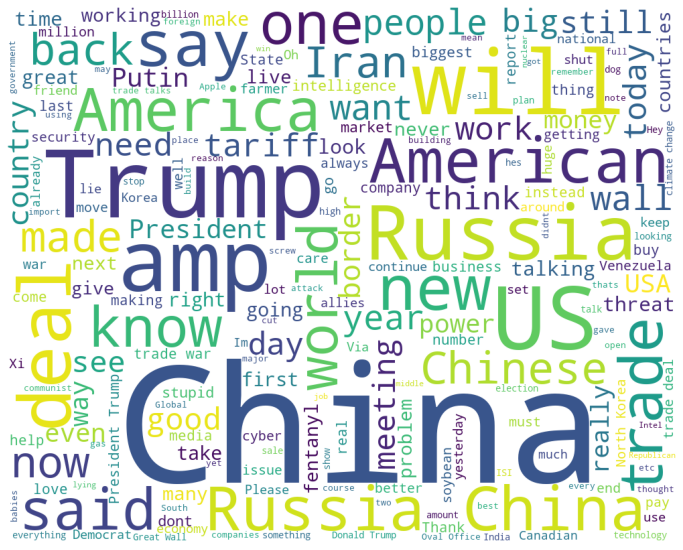

In [76]:
word_cloud(df_tweets.head(500)['Text'])

# **Stock dataset collection**

Yahoo! Finance is a media property that is part of the Yahoo! network. It provides financial news, data and commentary including stock quotes, press releases, financial reports, and original content.

In [85]:
pip install yfinance

     |████████████████████████████████| 6.3 MB 13.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=05089f8138fce046abc325540703f0da1e9b07e3f8a1d2894d59c70e1ddd4486
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [86]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
def get_asset_data(ticker,start,end,interval):
  ticker_y=yf.Ticker(ticker)
  data=ticker_y.history(start=start,end=end,interval=interval)
  return data

In [78]:
def compute_return(data):
  data['Log returns'] = (np.log(data.Close /data.Close.shift(-1)))
  return data

In [79]:
def compute_volatility(data):
    return data['Log returns'].std()*252**.5

Just to show the effectivenes of yahoo finance, we will show an example on how to use it in the following cells.

In [88]:
stock_name = "ZS=F" # the name of a soy stock, one of the sectors that was 
                    # mostly affected during the trade war
stockSoyBeans= yf.Ticker(stock_name)
stockSoyBeans

yfinance.Ticker object <ZS=F>

In [89]:
stock_data=get_asset_data(stock_name,start="2018-01-01", end="2019-01-01", interval="1d")

In [90]:
stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02,956.50,960.00,949.50,955.00,2900,0,0
2018-01-03,956.25,960.50,955.00,959.75,2582,0,0
2018-01-04,959.25,960.00,950.25,959.25,2133,0,0
2018-01-05,960.00,966.50,960.00,961.50,1278,0,0
2018-01-08,960.75,962.25,951.50,958.25,988,0,0


In [92]:
stock_data_augmented = compute_return(stock_data)

In [94]:
stock_data_augmented.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log returns
Date,,,,,,,,
2018-01-02,956.50,960.00,949.50,955.00,2900,0,0,-0.004961
2018-01-03,956.25,960.50,955.00,959.75,2582,0,0,0.000521
2018-01-04,959.25,960.00,950.25,959.25,2133,0,0,-0.002343
2018-01-05,960.00,966.50,960.00,961.50,1278,0,0,0.003386
2018-01-08,960.75,962.25,951.50,958.25,988,0,0,0.002612


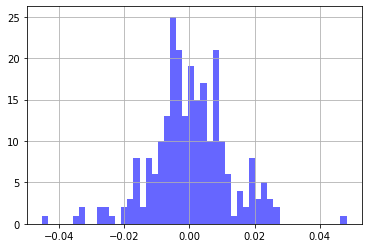

In [96]:
fig, ax = plt.subplots()
stock_data_augmented['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b', )

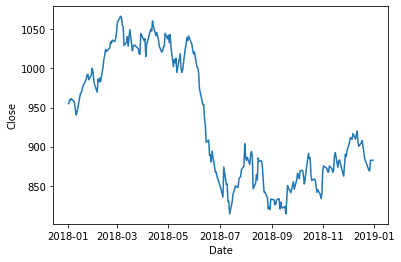

In [98]:
 sns.lineplot(data=stock_data_augmented, x="Date", y="Close")

In [ ]:
# Save the stock
file_name_stock = "example_stock.csv"
stock_data_augmented.to_csv(file_name_stock, sep=',')